In [25]:
from os.path import expanduser
import os


def load_env():
    home = expanduser("~")
    print(home)
    with open(home+'/.env', 'r') as f:
        env = dict()
        for line in f.readlines():
            key, value = line.split('=')
            env[key] = value.split('\n')[0]
        return env

def export_env():
    """Loads your .env file and exports the three variables important for mlflow.
    MLFLOW_TRACKING_USERNAME, MLFLOW_TRACKING_PASSWORD, MLFLOW_TRACKING_URI
    """
    env = load_env()
    for key in ["MLFLOW_TRACKING_USERNAME", "MLFLOW_TRACKING_PASSWORD", "MLFLOW_TRACKING_URI"]:
        os.environ[key] = env[key]

In [26]:
### RUN FIRST:
### sudo openvpn --config kit.ovpn

import mlflow
from mlflow_utils.load_env import export_env

export_env()
mlflow.set_experiment("demo")

Now for sake of simplicity to demonstrate how mlflow works in conjunction with tensorflow we can work with an example using e.g. the car dataset:

In [6]:
import pysftp
import paramiko
import os
import numpy as np

class GDB9_data_instance:
    def __init__(self, sftp, path):
        if not os.path.exists(path):
            raise Exception("Path {} does not exist.".format(path))
        num_of_atoms = int(f.readline())
        self.scalar_properties = f.readline().strip().replace("gdb ","").split("\t")
        self.scalar_properties = [float(p) for p in self.scalar_properties]
        self.scalar_properties[0] = int(self.scalar_properties[0])
        self.atoms = []
        for i in range(num_of_atoms):
            atom_posXYZ_MullikenPartialCharge = f.readline().strip().replace(" ","").replace("*^","e").split("\t")
            self.atoms.append(atom_posXYZ_MullikenPartialCharge)
        self.harmonic_vibrational_frequencies = f.readline().strip().split("\t")
        (self.gdb17_smile, self.b3lyp_relaxation_smile) = f.readline().strip().split("\t")
        (self.corina_InChI, self.b3lyp_InChI) = f.readline().strip().split("\t")
        
        
gdb9_data_dir = r"dsgdb9nsd"
gdb9_data = []
amount = 10
currently_checked = 0

config = paramiko.config.SSHConfig()
config.parse(open(os.path.expanduser('~/.ssh/config')))
conf = config.lookup('lsdf')
with pysftp.Connection(host=conf['hostname'], username=conf['user'], private_key=conf['identityfile'][0]) as sftp:
    dataset_path = '/lsdf/kit/iti/projects/aimat-mlflow/datasets/dsgdb9nsd'
    with sftp.cd(dataset_path):
        #for file in sftp.listdir(gdb9_data_dir):
        #    print(sftp.listdir())
        for file in sftp.listdir():
            if len(gdb9_data) > amount or currently_checked > amount:
                break
            currently_checked += 1
            lstatout = str(sftp.lstat(file)).split()[0]
            #if 'd' not in lstatout:
            #    print file, 'is a file'
            if file.endswith(".xyz"):
                print(file)
                try:
                    file_path = os.path.join(dataset_path, file)
                    local_path = os.path.join('/temp',file_path)
                    sftp.get(file_path, local_path)
                    gdb9_data.append(GDB9_data_instance(local_path))
                except Exception as e:
                    print(e)
                
        # sftp.get('')         # get a remote file

dsgdb9nsd_000001.xyz
dsgdb9nsd_000002.xyz
dsgdb9nsd_000003.xyz
dsgdb9nsd_000004.xyz
dsgdb9nsd_000005.xyz
dsgdb9nsd_000006.xyz
dsgdb9nsd_000007.xyz
dsgdb9nsd_000008.xyz
dsgdb9nsd_000009.xyz
dsgdb9nsd_000010.xyz
dsgdb9nsd_000011.xyz


In [ ]:
gdb9_data

In [ ]:
smiles = [gdb9data.gdb17_smile for gdb9data in gdb9_data]
homo_energies = [gdb9data.scalar_properties[6] for gdb9data in gdb9_data]

In [27]:
import pandas as pd
import numpy as np

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names,
                      na_values='?', comment='\t',
                      sep=' ', skipinitialspace=True)
dataset = dataset.dropna()
# One-hot encode origin:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


Let's split it into train and test datasets:

In [28]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

train_dataset.describe().transpose()[['mean', 'std']]

/home/erik/miniconda2/envs/automol/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


...and fit a normalizer on the train data:

In [29]:
from tensorflow.keras.layers.experimental import preprocessing

normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

/home/erik/miniconda2/envs/automol/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
import matplotlib.pyplot as plt

def plot_learning_curve(title, train_scores, test_scores, fit_times, 
                        axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [31]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

mlflow.sklearn.autolog()

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

#model = MLPRegressor(random_state=1, max_iter=300)
model = RandomForestRegressor()

with mlflow.start_run() as run:
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(model, train_features, train_labels, cv=cv, n_jobs=None, return_times=True)

2021/01/23 15:23:36 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under sftp://lsdf/kit/iti/projects/aimat-mlflow/artifacts/1/dc3fc1c9605d4e869e5f0aa85e85e130/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.
2021/01/23 15:23:39 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under sftp://lsdf/kit/iti/projects/aimat-mlflow/artifacts/1/dc3fc1c9605d4e869e5f0aa85e85e130/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, con

/home/erik/miniconda2/envs/automol/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'matplotlib.pyplot' from '/home/erik/miniconda2/envs/automol/lib/python3.8/site-packages/matplotlib/pyplot.py'>

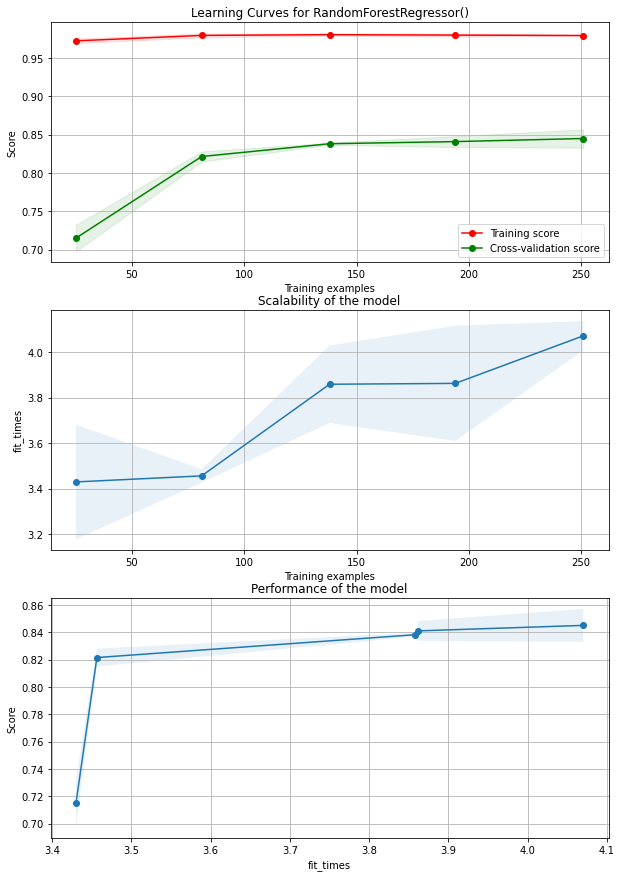

In [32]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
title = "Learning Curves for " + str(model)

plot_learning_curve(title, train_scores, test_scores, fit_times, 
                    #axes=axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4, train_sizes=train_sizes)
                    axes=axes, cv=cv, n_jobs=4, train_sizes=train_sizes)

In [33]:
from pprint import pprint

def fetch_logged_data(run_id):
    client = mlflow.tracking.MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts

params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)

pprint(params)
pprint(metrics)
pprint(tags)
pprint(artifacts)

/home/erik/miniconda2/envs/automol/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'bootstrap': 'True',
 'ccp_alpha': '0.0',
 'criterion': 'mse',
 'max_depth': 'None',
 'max_features': 'auto',
 'max_leaf_nodes': 'None',
 'max_samples': 'None',
 'min_impurity_decrease': '0.0',
 'min_impurity_split': 'None',
 'min_samples_leaf': '1',
 'min_samples_split': '2',
 'min_weight_fraction_leaf': '0.0',
 'n_estimators': '100',
 'n_jobs': 'None',
 'oob_score': 'False',
 'random_state': 'None',
 'verbose': '0',
 'warm_start': 'False'}
{'training_mae': 0.7204183266932266,
 'training_mse': 1.1985097250996,
 'training_r2_score': 0.9799565691643131,
 'training_rmse': 1.0947646893737484,
 'training_score': 0.9799565691643131}
{'estimator_class': 'sklearn.ensemble._forest.RandomForestRegressor',
 'estimator_name': 'RandomForestRegressor'}
['model/MLmodel', 'model/conda.yaml', 'model/model.pkl']
